# LSTM Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dataclasses import dataclass
from typing import Union, Tuple, List

2022-11-23 16:55:51.805335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 16:55:52.568317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-23 16:55:52.568406: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-23 16:55:52.634040: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-23 16:55:53.939632: W tensorflow/stream_executor/platform/de

In [2]:
# Read the data.
df = pd.read_csv('smoothed_data_kansas.csv')
x = np.concatenate((df['x_19'], df['x_20'], df['x_22']), axis=0)
# NDVI time series.
y = np.concatenate((df['y_19'], df['y_20'], df['y_22']), axis=0)
# Generate the time vector in days after planting.
time = [i for i in range(len(y))]

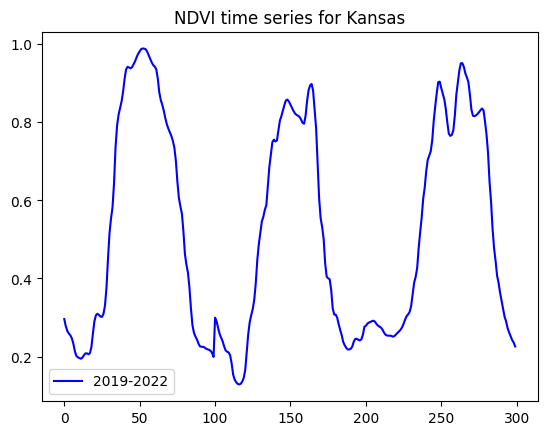

In [3]:
plt.title('NDVI time series for Kansas')
plt.plot(time, y, 'b', label='2019-2022')
plt.legend()
plt.show()

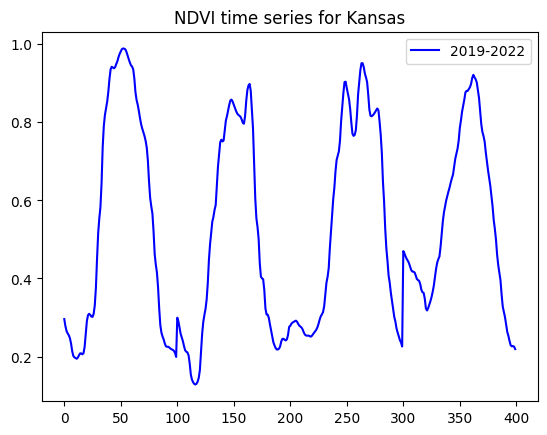

In [9]:
df["y_23"] = df[["y_19", "y_20", "y_21"]].mean(axis=1)
y = np.concatenate((df['y_19'], df['y_20'], df['y_22'], df["y_23"]), axis=0)
time = [i for i in range(len(y))]
plt.title('NDVI time series for Kansas')
plt.plot(time, y, 'b', label='2019-2023')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

evaluation = df[["y_19", "y_20", "y_21"]]
evaluated = df["y_23"]

for column in evaluation.columns:
    rmse = np.sqrt(mean_squared_error(evaluation[column], evaluated))
    print(rmse)

0.14704919840419095
0.15649904549007276
0.2800161069210727


In [13]:
print(np.sqrt(0.002503))

0.05002999100539595


In [220]:
# Time series parameters.
@dataclass
class PARAMETERS:
  TIME, SERIES = time, y
  # Number of days to be used on the training set.
  SPLIT_TIME = 200
  # Data points to make our prediction.
  WINDOW_SIZE = 25
  # How many items will we supply per batch.
  BATCH_SIZE = 32
  # Define the Tensorflow sample buffer.
  SHUFFLE_BUFFER_SIZE = 1000
  # Number of epochs.
  EPOCHS = 50
  # Next t steps to predeict.
  PREDICT_STEPS = 100
  # Acceptable error threshold
  THRESHOLD = 0.04

In [221]:
def train_val_split(
  time: Union[List, np.ndarray],
  series: Union[List, np.ndarray],
  time_step: int = PARAMETERS.SPLIT_TIME
) -> Tuple[np.ndarray, ...]:
  """
  Divide the time series into training and validation set.
  """
  assert isinstance(time, (np.ndarray, list))
  
  # Training time vector.
  time_train = time[:time_step]
  # NDVI series vector.
  series_train = series[:time_step]
  # Validation time vector.
  time_valid = time[time_step:]
  # NDVI series vector.
  series_valid = series[time_step:]
  
  return time_train, series_train, time_valid, series_valid

def windowed_dataset(
	series: Union[List, np.ndarray],
	window_size: int = PARAMETERS.WINDOW_SIZE,
	batch_size: int = PARAMETERS.BATCH_SIZE,
	shuffle_buffer: int = PARAMETERS.SHUFFLE_BUFFER_SIZE
) -> tf.data.Dataset:
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
	"""
	# Create a TensorFlow dataset from np.arrays or lists.
	dataset = tf.data.Dataset.from_tensor_slices(series)
	# Create a DataFrame of windows.
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	# Flat the vectors and make batches of the data.
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	# Randomly shuffle the data.
	dataset = dataset.shuffle(shuffle_buffer)
	# Transform the data to the format X, y.
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	# Prefetch.
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [222]:
# Split the data into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(PARAMETERS.TIME, PARAMETERS.SERIES)

In [223]:
# Create the dataset with time windows.
dataset = windowed_dataset(series_train)

In [224]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < PARAMETERS.THRESHOLD):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [225]:
def create_model():
  """
  Function to define a sequential model.
  Appropriate for a plain stack of layers where 
  each layer has exactly ONE input tensor and ONE output tensor.
  """
  # Set a random seed.
  tf.random.set_seed(51)

  # Uncompiled model.
  model = tf.keras.models.Sequential([
      # Lambda layer to handle the input data format. 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                              input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      # Layer of prediction.
      tf.keras.layers.Dense(1),
  ])
  
  # Compile model for training.
  model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
  )

  return model

In [226]:
# Call and create the model.
model = create_model()

In [227]:
# Training and assign the callback
history = model.fit(dataset, epochs=PARAMETERS.EPOCHS, callbacks=[early_stopping])

Epoch 1/50
6/6 [==============================] - 18s 1s/step - loss: 0.1922 - mae: 0.5120
Epoch 2/50
6/6 [==============================] - 7s 1s/step - loss: 0.0337 - mae: 0.2111
Epoch 3/50
6/6 [==============================] - 8s 1s/step - loss: 0.0241 - mae: 0.1791
Epoch 4/50
6/6 [==============================] - 9s 1s/step - loss: 0.0095 - mae: 0.1113
Epoch 5/50
6/6 [==============================] - 8s 1s/step - loss: 0.0051 - mae: 0.0826
Epoch 6/50
6/6 [==============================] - 8s 1s/step - loss: 0.0031 - mae: 0.0660
Epoch 7/50
6/6 [==============================] - 8s 1s/step - loss: 0.0024 - mae: 0.0569
Epoch 8/50
6/6 [==============================] - 8s 1s/step - loss: 0.0023 - mae: 0.0546
Epoch 9/50
6/6 [==============================] - 8s 1s/step - loss: 0.0022 - mae: 0.0520
Epoch 10/50
6/6 [==============================] - 9s 1s/step - loss: 0.0018 - mae: 0.0473
Epoch 11/50
6/6 [==============================] - 7s 1s/step - loss: 0.0016 - mae: 0.0445
Epoch 1

In [228]:
def compute_metrics(
  true_series : Union[List, np.ndarray],
  forecast : Union[List, np.ndarray]
) -> Tuple[float, float]:
  """
  Print MSE and MAE
  """
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

  return mse, mae

In [229]:
def model_forecast(
  model, 
  series: np.ndarray, 
  window_size: int
) -> np.ndarray:
  """
  Converts the input series into a dataset with time windows for forecasting.
  """
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  
  return forecast

In [230]:
# Prediction on the whole series.
all_forecast = model_forecast(model, PARAMETERS.SERIES, PARAMETERS.WINDOW_SIZE).squeeze()

# Validation portion.
val_forecast = all_forecast[PARAMETERS.SPLIT_TIME - PARAMETERS.WINDOW_SIZE:-1]

9/9 [==============================] - 5s 318ms/step


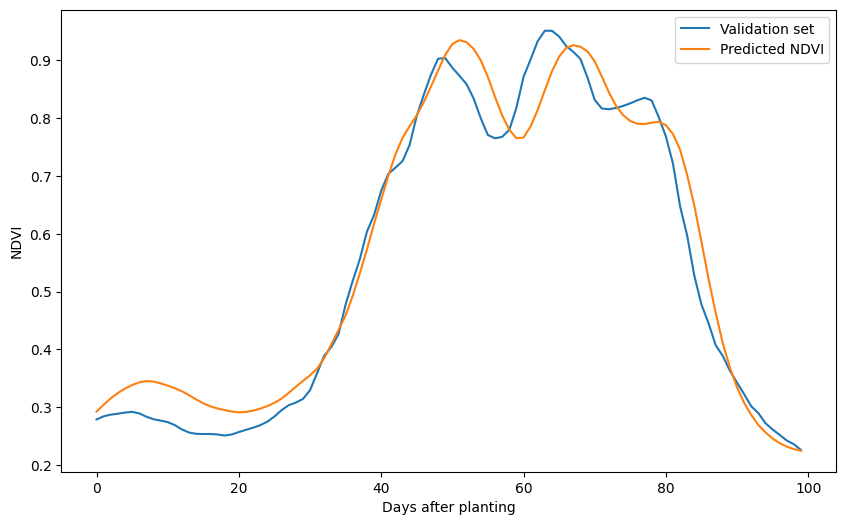

In [231]:
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="Validation set")
plt.plot(val_forecast, label="Predicted NDVI")
plt.xlabel("Days after planting")
plt.ylabel("NDVI")
plt.legend()
plt.show()

In [232]:
mse, mae = compute_metrics(series_valid, val_forecast)
print(f"mse: {mse:5f}, mae: {mae:5f}")

mse: 0.002503, mae: 0.039674


In [233]:
# Get the forecast of the model.
new_forecast = []

for i in range(PARAMETERS.PREDICT_STEPS):
  new_forecast_series = PARAMETERS.SERIES[-PARAMETERS.WINDOW_SIZE:]  
  pred = model.predict(new_forecast_series[np.newaxis])
  new_forecast.append(pred.reshape(-1))
  PARAMETERS.SERIES = np.append(PARAMETERS.SERIES, pred)

# Crete the new time vector.
new_time = [i for i in range(len(PARAMETERS.TIME) + 1, len(PARAMETERS.TIME) + PARAMETERS.PREDICT_STEPS + 1)]

1/1 [==============================] - 0s 73ms/step


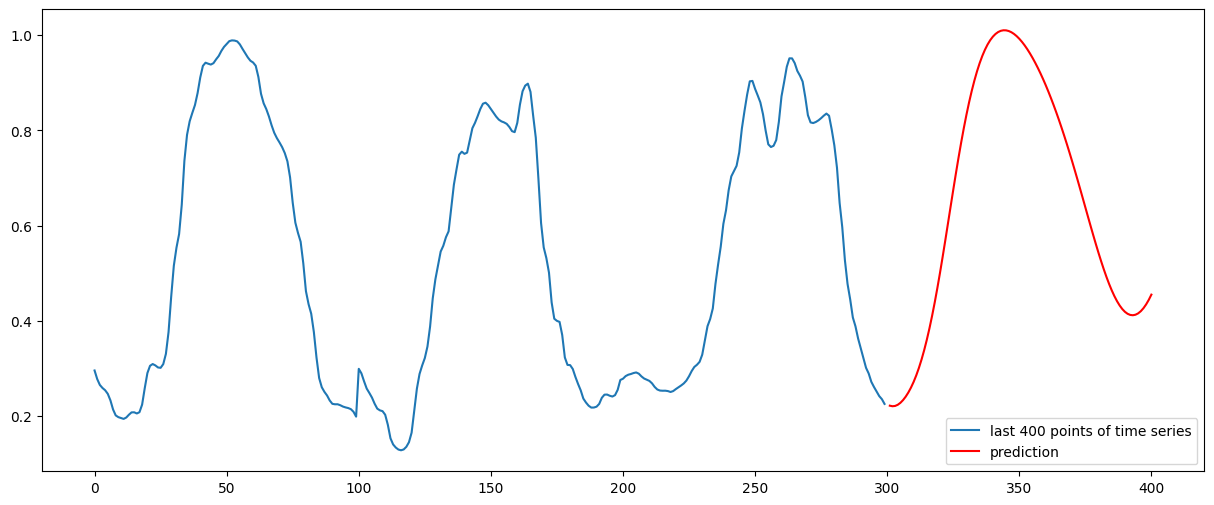

In [234]:
plt.figure(figsize=(15, 6))
plt.plot(PARAMETERS.TIME[:300], PARAMETERS.SERIES[:300], label="last 400 points of time series")
plt.plot(new_time, new_forecast, color="red", label="prediction")
plt.legend()
plt.show()

In [244]:
# Read the data.
df_ = pd.read_csv('smoothed_data_Kansas2.csv')
x_ = np.concatenate((df['x_19'], df['x_20'], df['x_22']), axis=0)
# NDVI time series.
y_ = np.concatenate((df['y_19'], df['y_20'], df['y_22']), axis=0)
# Generate the time vector in days after planting.
time_ = [i for i in range(len(y_))]

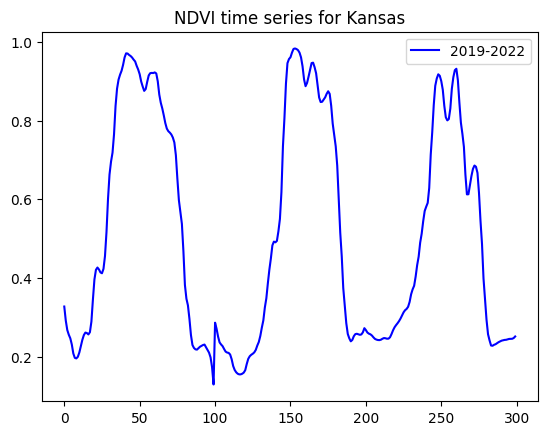

In [245]:
plt.title('NDVI time series for Kansas')
plt.plot(time_, y_, 'b', label='2019-2022')
plt.legend()
plt.show()

In [246]:
# Get the forecast of the model.
new_forecast_ = []

for i in range(PARAMETERS.PREDICT_STEPS):
  new_forecast_series = y_[-PARAMETERS.WINDOW_SIZE:]  
  pred = model.predict(new_forecast_series[np.newaxis])
  new_forecast.append(pred.reshape(-1))
  y_ = np.append(y_, pred)

# Crete the new time vector.
new_time_ = [i for i in range(PARAMETERS.PREDICT_STEPS + 1)]

1/1 [==============================] - 0s 82ms/step


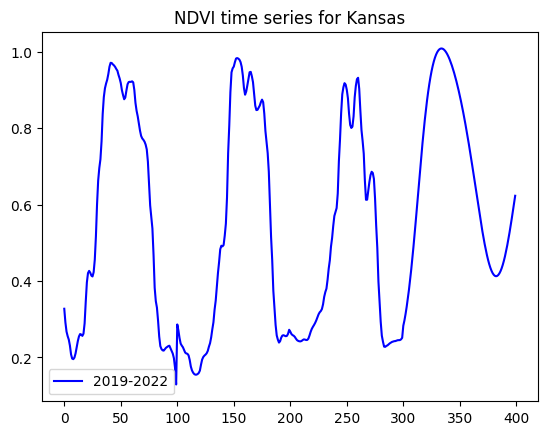

In [247]:
plt.title('NDVI time series for Kansas')
plt.plot(y_, 'b', label='2019-2022')
plt.legend()
plt.show()